# Tutorial for a new pointing API and a pointing systematics.


In [ ]:
import logging

import healpy as hp
import matplotlib.pylab as plt
import numpy as np
import tomlkit

import litebird_sim as lbs

logging.getLogger("healpy").setLevel(logging.WARNING)

Let's define useful function to generate `Simulation` and list of `DetectorInfo`.


In [ ]:
telescope = "LFT"
start_time = 0

imo_version = "vPTEP"
imo = lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION)

duration_s = 10
sampling_hz = 19.0
random_seed = 12345


def gen_simulation_and_dets(
    telescope,
    duration_s,
    sampling_hz,
    random_seed,
    hwp_rpm=None,
    scan_strategy=True,
):
    """Generate a simulation and detectors with a argument of scan_strategy.
    If scan_strategy is True, the scanning strategy is set by the IMO file.
    If scan_strategy is False, the spacecraft stops spinning and precession.

    Args:
        telescope (str): Telescope name.
        duration_s (float): Duration of simulation.
        sampling_hz (float): Sampling frequency.
        random_seed (int): Random seed.
        hwp_rpm (float, optional): HWP rotation speed. Defaults to None.
        scan_strategy (bool, optional): If True, the scanning strategy is set by the IMO file. Defaults to True.

    Returns:
        lbs.Simulation
        list: List of detectors.
    """
    sim = lbs.Simulation(
        start_time=start_time, duration_s=duration_s, random_seed=random_seed
    )
    if scan_strategy:
        sim.set_scanning_strategy(
            imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/",
            delta_time_s=1.0 / sampling_hz,
        )
    else:
        sim.set_scanning_strategy(
            scanning_strategy=lbs.SpinningScanningStrategy(
                spin_sun_angle_rad=np.deg2rad(45.0),
                spin_rate_hz=0.0,
                precession_rate_hz=0.0,
            ),
            delta_time_s=1.0 / sampling_hz,
        )
    sim.set_instrument(
        lbs.InstrumentInfo.from_imo(
            imo,
            f"/releases/{imo_version}/satellite/{telescope}/instrument_info",
        )
    )

    if hwp_rpm is not None:
        sim.set_hwp(lbs.IdealHWP(hwp_rpm * 2 * np.pi / 60))
        sim.instrument.hwp_rpm = hwp_rpm
    else:
        sim.set_hwp(lbs.IdealHWP(sim.instrument.hwp_rpm * 2 * np.pi / 60))
    dets = []
    path_of_toml = "../test/pointing_sys_reference/mock_focalplane.toml"
    with open(path_of_toml, "r", encoding="utf-8") as toml_file:
        toml_data = tomlkit.parse(toml_file.read())
        for i in range(len(toml_data[telescope])):
            det = lbs.DetectorInfo.from_dict(toml_data[telescope][f"det_{i:03}"])
            det.sampling_rate_hz = sampling_hz
            dets.append(det)
    return sim, dets


def get_hitmap(nside, pointings):
    """Get hitmap from pointings.

    Args:
        nside (int): nside of healpix.
        pointings (np.ndarray): Pointings of detectors.

    Returns:
        np.ndarray: Hitmap
    """
    npix = hp.nside2npix(nside)
    ipix = hp.ang2pix(nside, pointings[:, :, 0], pointings[:, :, 1])
    hitmap, _ = np.histogram(ipix, bins=np.arange(npix + 1))
    return hitmap

In the new pointing API allows to calculate pointing in the method of `.Observation`
To obtain all detectors pointing that you specified, you just call `Observation.get_pointings("all")` as below:


In [ ]:
sim, dets = gen_simulation_and_dets(telescope, duration_s, sampling_hz, random_seed)

sim.create_observations(detectors=dets)

lbs.prepare_pointings(
    sim.observations, sim.instrument, sim.spin2ecliptic_quats, hwp=sim.hwp
)

pointings_no_syst, hwp_angle = sim.observations[0].get_pointings("all")

The same result can be obtained by accessing each instance using a for loop as follows:


In [4]:
pointings_ = []
for cur_obs in sim.observations:
    for det_idx in range(cur_obs.n_detectors):
        pnt, _ = cur_obs.get_pointings(det_idx, pointings_dtype=np.float64)
        pointings_.append(pnt)
pointings_ = np.array(pointings_)

assert np.allclose(pointings_no_syst, pointings_)

Thanks to the new pointing API, we can control the time dependency of the quaternion to generate pointings.
The `Class: PointingSys` contains essential functionality to simulate a systematics that can happen around pointing, e.g. constant offset, vibration and so on.

These systematics need to be simulated on a specific coordinate, such as a Forcal plane coordinate and a spacecraft coordinate.
`PointingSys` can simulate several situations of pointing systematics:

- Forcal plane coordinate
  - Time-independent
    - Global offset: Each detector has an offset of the same magnitude and direction.
    - Individual offset per detector: Each detector has offset of different magnitude and direction.
  - Time-dependent
    - Global offset: Each detector has the same disturbance.
    - Individual disturbance det. by det: Each detector has different disturbance.
- Spacecraft coordinate

  - Time independent
    - Global offset: Spacecraft misinterprets its spin axis.
  - Time-dependent
    - Global disturbance: The whole spacecraft is affected by the same perturbation, e.g. due to a cryogenic system, internal noise of the star tracker.

- HWP coordinate
  - Time-dependent
    - Common disturbance per telescope: Pointing circular disturbance given by wedged HWP (or tilted refrective HWP). This effect rotates pointings around expected pointing direction with a constant angular radius.

Here we describe the use of `PointingSys` to simulate each point.


## FP coord / time-independent / global offset


In [5]:
# rotation axis for the offset in the focal plane coordinate
axes = ["x", "y", "z"]
pointings_list = []
global_offset_deg = 10.0

for ax in axes:
    sim_sys, dets_sys = gen_simulation_and_dets(
        telescope, duration_s, sampling_hz, random_seed
    )

    sim_sys.create_observations(detectors=dets_sys)
    # Define the instance of the `PointingSys`
    pntsys = lbs.PointingSys(sim_sys, sim_sys.observations[0], dets_sys)
    # Add the global offset to the focal plane
    pntsys.focalplane.add_offset(np.deg2rad(global_offset_deg), ax)

    lbs.prepare_pointings(
        sim_sys.observations,
        sim_sys.instrument,
        sim_sys.spin2ecliptic_quats,
        hwp=sim_sys.hwp,
    )

    pointings_sys, hwp_angle = sim_sys.observations[0].get_pointings("all")
    pointings_list.append(pointings_sys)

We can see how the global offset is injected in the pointings in the below hitmap which is calculated with a single timestamp:


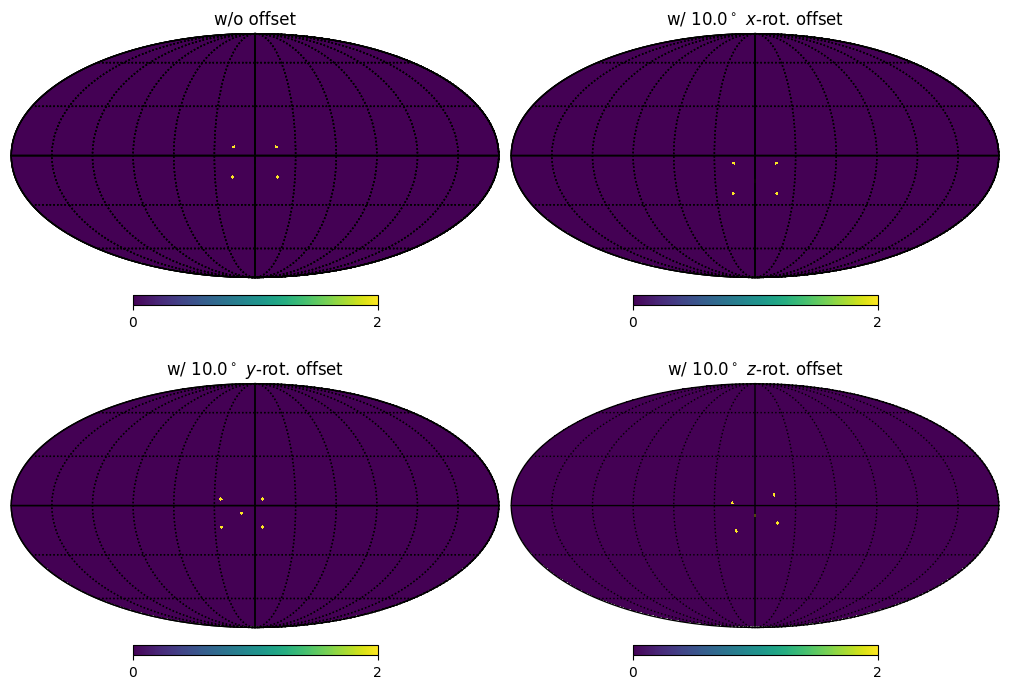

In [6]:
nside = 32
hitmap = get_hitmap(
    nside,
    pointings_no_syst[
        :,
        :1,
        :,
    ],
)

plt.figure(figsize=(10, 7))
hp.mollview(hitmap, sub=(2, 2, 1), title="w/o offset")
hp.graticule()
for i, ax in enumerate(axes):
    hitmap_sys = get_hitmap(nside, pointings_list[i][:, :1])
    hp.mollview(
        hitmap_sys,
        sub=(2, 2, i + 2),
        title=rf"w/ {global_offset_deg}$^\circ$ ${ax}$-rot. offset",
    )
    hp.graticule()

## FP coord / time-independent / individual offset det. by det.


In [7]:
pointings_list = []

sim_sys, dets_sys = gen_simulation_and_dets(
    telescope, duration_s, sampling_hz, random_seed
)

det1_offset = 10.0
uncommon_offsets_deg = [
    0,
    0,
    det1_offset,
    det1_offset,
    0,
    0,
    0,
    0,
    0,
    0,
]  # [det0_top, det0_bottom, det1_top, det1_bottom,...]

sim_sys.create_observations(detectors=dets_sys)

# Just you need to put array of the offsets in the focal plane coordinate
pntsys = lbs.PointingSys(sim_sys, sim_sys.observations[0], dets_sys)
pntsys.focalplane.add_offset(np.deg2rad(uncommon_offsets_deg), "x")
pntsys.focalplane.add_offset(np.deg2rad(uncommon_offsets_deg), "y")


lbs.prepare_pointings(
    sim_sys.observations,
    sim_sys.instrument,
    sim_sys.spin2ecliptic_quats,
    hwp=sim_sys.hwp,
)

pointings_sys, hwp_angle = sim_sys.observations[0].get_pointings("all")
pointings_list.append(pointings_sys)

One detector that has turned 10 deg. on the $x$-axis and then 10 deg. on the $y$-axis can be identified.


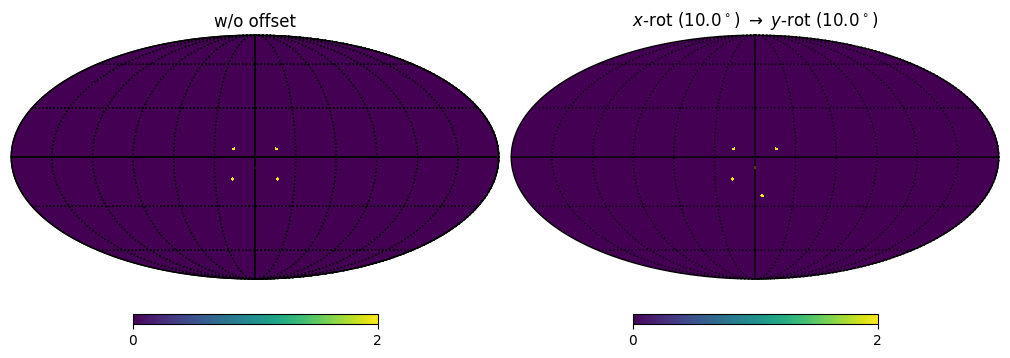

In [8]:
hitmap = get_hitmap(
    nside,
    pointings_no_syst[
        :,
        :1,
        :,
    ],
)

plt.figure(figsize=(10, 7))
hp.mollview(hitmap, sub=(1, 2, 1), title="w/o offset")
hp.graticule()

hitmap_sys = get_hitmap(nside, pointings_list[0][:, :1])
hp.mollview(
    hitmap_sys,
    sub=(1, 2, 2),
    title=rf"$x$-rot ({det1_offset}$^\circ$) $\rightarrow$ $y$-rot ({det1_offset}$^\circ$)",
)
hp.graticule()

## FP coord / time-dependent / global disturbance


In [ ]:
duration_s = 10
sampling_hz = 10.0

sim_sys, dets_sys = gen_simulation_and_dets(
    telescope,
    duration_s,
    sampling_hz,
    random_seed,
    scan_strategy=False,  # STOP scanning to see the effect of the white noise
)

sim_sys.create_observations(detectors=dets_sys)

nquats = sim_sys.observations[0].n_samples + 1
pntsys = lbs.PointingSys(sim_sys, sim_sys.observations[0], dets_sys)

# Add the white noise to the focal plane
noise_rad_array_x = np.zeros(nquats)
noise_rad_array_y = np.zeros(nquats)
noise_sigma_deg = 3.0

# make a white noise with the unit of radian.
lbs.add_white_noise(
    noise_rad_array_x, sigma=np.deg2rad(noise_sigma_deg), random=sim_sys.random
)
lbs.add_white_noise(
    noise_rad_array_y, sigma=np.deg2rad(noise_sigma_deg), random=sim_sys.random
)

pntsys.focalplane.add_disturb(noise_rad_array_x, "x")
pntsys.focalplane.add_disturb(noise_rad_array_y, "y")

pointings_list = []
lbs.prepare_pointings(
    sim_sys.observations,
    sim_sys.instrument,
    sim_sys.spin2ecliptic_quats,
    hwp=sim_sys.hwp,
)

pointings_list, _ = sim_sys.observations[0].get_pointings("all")

Within 10 secconds observation with 10 Hz sampling rate, we can see the gaussian stracture in the hitmap due to the white noise that we injected.
Note that we stap the scanning motion.


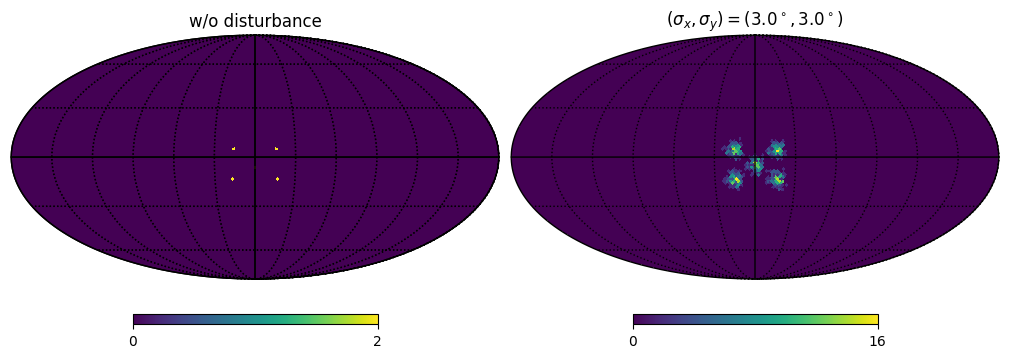

In [10]:
nside = 32
hitmap = get_hitmap(
    nside,
    pointings_no_syst[
        :,
        :1,
        :,
    ],
)

plt.figure(figsize=(10, 7))
hp.mollview(hitmap, sub=(1, 2, 1), title="w/o disturbance")
hp.graticule()

hitmap_sys = get_hitmap(nside, pointings_list)
hp.mollview(
    hitmap_sys,
    sub=(1, 2, 2),
    title=f"$(\sigma_x,\sigma_y)=({noise_sigma_deg}^\circ, {noise_sigma_deg}^\circ)$",
)
hp.graticule()

## FP coord / time-dependent / individual disturbance det. by det.


In [11]:
duration_s = 10
sampling_hz = 10.0

sim_sys, dets_sys = gen_simulation_and_dets(
    telescope, duration_s, sampling_hz, random_seed, scan_strategy=False
)
sim_sys.create_observations(detectors=dets_sys)

nquats = sim_sys.observations[0].n_samples + 1

# make a noise with a shape of (num. of detectors, num. of quats.)
noise_matrix_rad_x = np.zeros([len(dets_sys), nquats])
noise_matrix_rad_y = np.zeros([len(dets_sys), nquats])
noise_sigma_deg = 3.0

for i in range(len(dets_sys)):
    lbs.add_white_noise(
        noise_matrix_rad_x[i, :],
        sigma=np.deg2rad(noise_sigma_deg),
        random=sim_sys.random,
    )
    lbs.add_white_noise(
        noise_matrix_rad_y[i, :],
        sigma=np.deg2rad(noise_sigma_deg),
        random=sim_sys.random,
    )

# [number of detectors, number of quaternions]
print("noise_matrix_rad_x.shape [ndet, nsample]: ", noise_matrix_rad_x.shape)

pntsys = lbs.PointingSys(sim_sys, sim_sys.observations[0], dets_sys)

# Add the white noise to each detector in the focal plane
pntsys.focalplane.add_disturb(noise_matrix_rad_x, "x")
pntsys.focalplane.add_disturb(noise_matrix_rad_y, "y")

pointings_list = []

lbs.prepare_pointings(
    sim_sys.observations,
    sim_sys.instrument,
    sim_sys.spin2ecliptic_quats,
    hwp=sim_sys.hwp,
)

pointings_list, _ = sim_sys.observations[0].get_pointings("all")

noise_matrix_rad_x.shape [ndet, nsample]:  (10, 101)


The middle map is calcurated single timestamp, we can see the pointing of detectors individually subjected to disturbance.

After integrated by time, it will be a gaussian like in the right.


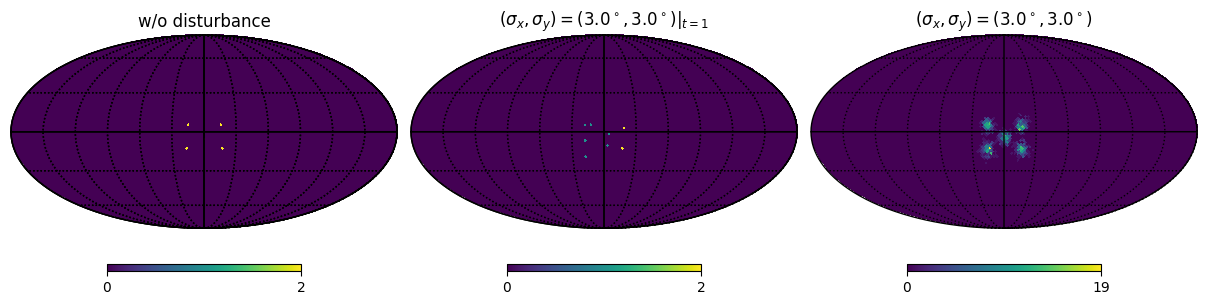

In [ ]:
nside = 32
hitmap = get_hitmap(
    nside,
    pointings_no_syst[
        :,
        :1,
        :,
    ],
)

plt.figure(figsize=(12, 7))
hp.mollview(hitmap, sub=(1, 3, 1), title="w/o disturbance")
hp.graticule()

time_snap = 1
hitmap_sys_t1 = get_hitmap(
    nside,
    pointings_list[
        :,
        time_snap - 1 : time_snap,
        :,
    ],
)
hp.mollview(
    hitmap_sys_t1,
    sub=(1, 3, 2),
    title=f"$(\sigma_x,\sigma_y)=({noise_sigma_deg}^\circ, {noise_sigma_deg}^\circ)$"
    + f"$|_{{t={time_snap}}}$",
)
hp.graticule()

hitmap_sys = get_hitmap(nside, pointings_list)
hp.mollview(
    hitmap_sys,
    sub=(1, 3, 3),
    title=f"$(\sigma_x,\sigma_y)=({noise_sigma_deg}^\circ, {noise_sigma_deg}^\circ)$",
)
hp.graticule()

## Spacecraft / time-independent / global offset


In [13]:
# 'x': perpendicular to the scan direction
# 'z': parallel to the scan direction

axes = ["x", "y", "z"]
pointings_list = []
global_offset_deg = 35.0

for ax in axes:
    sim_sys, dets_sys = gen_simulation_and_dets(
        telescope, duration_s, sampling_hz, random_seed
    )
    sim_sys.create_observations(detectors=dets_sys)
    pntsys = lbs.PointingSys(sim_sys, sim_sys.observations[0], dets_sys)

    # Specify `spacecraft` to add the global offset
    pntsys.spacecraft.add_offset(np.deg2rad(global_offset_deg), ax)

    lbs.prepare_pointings(
        sim_sys.observations,
        sim_sys.instrument,
        sim_sys.spin2ecliptic_quats,
        hwp=sim_sys.hwp,
    )

    pointings_sys, hwp_angle = sim_sys.observations[0].get_pointings("all")
    pointings_list.append(pointings_sys)

Note that in the FP example, the rotation was attached with respect to the boresight, but in the spacecraft coordinates, the spin axis is the reference. In particular, the $x$-axis offset is perpendicular to the scan direction and the $z$-axis offset is parallel to the scan direction, which changes the physical situation.


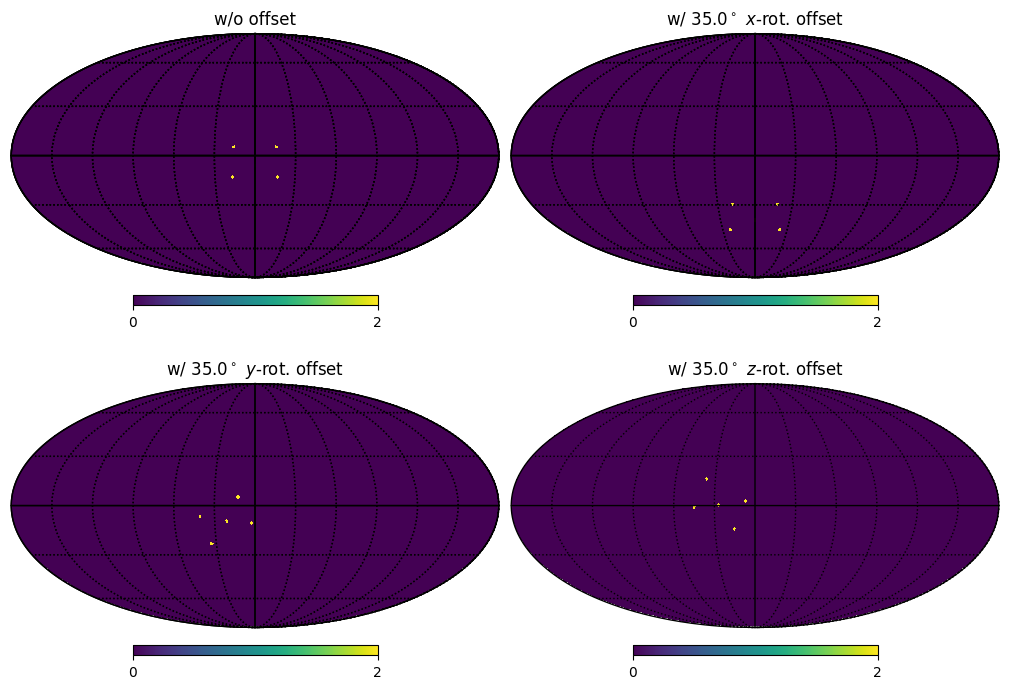

In [14]:
nside = 32
hitmap = get_hitmap(
    nside,
    pointings_no_syst[
        :,
        :1,
        :,
    ],
)

plt.figure(figsize=(10, 7))
hp.mollview(hitmap, sub=(2, 2, 1), title="w/o offset")
hp.graticule()
for i, ax in enumerate(axes):
    hitmap_sys = get_hitmap(nside, pointings_list[i][:, :1])
    hp.mollview(
        hitmap_sys,
        sub=(2, 2, i + 2),
        title=rf"w/ {global_offset_deg}$^\circ$ ${ax}$-rot. offset",
    )
    hp.graticule()

## Spacecraft / time-dependent / global disturbance


In [ ]:
duration_s = 10
sampling_hz = 10.0

sim_sys, dets_sys = gen_simulation_and_dets(
    telescope, duration_s, sampling_hz, random_seed, scan_strategy=False
)
sim_sys.create_observations(detectors=dets_sys)

nquats = sim_sys.observations[0].n_samples + 1

noise_rad_array_x = np.zeros(nquats)
noise_rad_array_z = np.zeros(nquats)
noise_sigma_deg = 3.0

# make a white noise with the unit of radian.
lbs.add_white_noise(
    noise_rad_array_x, sigma=np.deg2rad(noise_sigma_deg), random=sim_sys.random
)
lbs.add_white_noise(
    noise_rad_array_z, sigma=np.deg2rad(noise_sigma_deg), random=sim_sys.random
)

pntsys = lbs.PointingSys(sim_sys, sim_sys.observations[0], dets_sys)

# Add the white noise to the spacecraft
pntsys.spacecraft.add_disturb(noise_rad_array_x, "x")
pntsys.spacecraft.add_disturb(noise_rad_array_z, "z")


lbs.prepare_pointings(
    sim_sys.observations,
    sim_sys.instrument,
    sim_sys.spin2ecliptic_quats,
    hwp=sim_sys.hwp,
)

pointings_list, _ = sim_sys.observations[0].get_pointings("all")

We can see the disturbed pointings in the right hitmap.


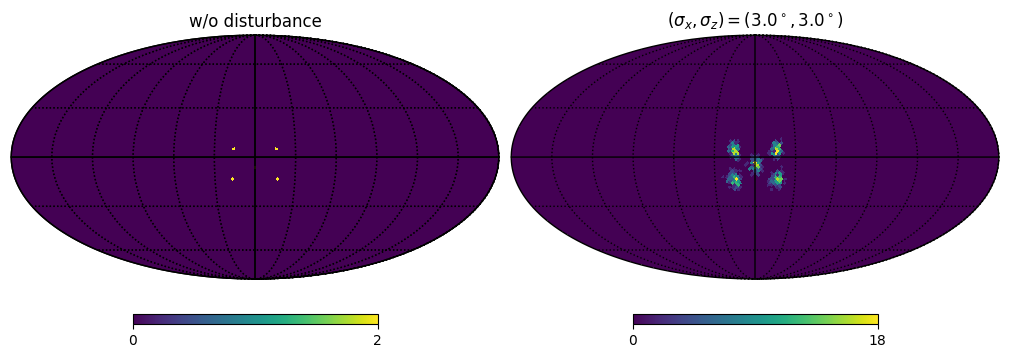

In [16]:
nside = 32
hitmap = get_hitmap(
    nside,
    pointings_no_syst[
        :,
        :1,
        :,
    ],
)

plt.figure(figsize=(10, 7))
hp.mollview(hitmap, sub=(1, 2, 1), title="w/o disturbance")
hp.graticule()

hitmap_sys = get_hitmap(nside, pointings_list)
hp.mollview(
    hitmap_sys,
    sub=(1, 2, 2),
    title=f"$(\sigma_x,\sigma_z)=({noise_sigma_deg}^\circ, {noise_sigma_deg}^\circ)$",
)
hp.graticule()

# Rotational disturbance due to the HWP

## Example of wedged HWP pointing systematics


In [ ]:
duration_s = 60
sampling_hz = 19.0
start_time = 0
hwp_rpm = 3

sim_sys, dets_sys = gen_simulation_and_dets(
    telescope, duration_s, sampling_hz, random_seed, hwp_rpm=hwp_rpm, scan_strategy=True
)
sim_sys.create_observations(detectors=dets_sys)

# Define the instance of the `PointingSys`
pntsys = lbs.PointingSys(sim_sys, sim_sys.observations[0], dets_sys)
refractive_idx = 3.1  # refractive index of the saphire
# wedge angle of the HWP, for the visulization it is set to big number to see the effect.
wedge_angle_deg = 3
wedge_angle_rad = np.deg2rad(wedge_angle_deg)

# Set the pointing shift angle from the expected pointing direction i.e. it is a deviation of the pointing direction.
# if pntsys.hwp.tilt_angle_rad = 0.0, the pointing is the same as the expected pointing direction.
# Now, we determin the deviation angle is given by the wedge angle and the refractive index of the HWP.
# Note that we assume the refractive index of ordinary and extra-ordinary axis of HWP has same value.
tilt_angle_rad = pntsys.hwp.get_wedgeHWP_pointing_shift_angle(
    wedge_angle_rad, refractive_idx
)

# Set the HWP rotation speed and the initial tilt (wedge direction) corresponding to the phase of the pointing deviation angle.
ang_speed_radpsec = sim_sys.instrument.hwp_rpm * 2 * np.pi / 60

# Add the HWP rotation disturbance to detector's quaternion in `dets_sys`
pntsys.hwp.add_hwp_rot_disturb(tilt_angle_rad, ang_speed_radpsec)

lbs.prepare_pointings(
    sim_sys.observations,
    sim_sys.instrument,
    sim_sys.spin2ecliptic_quats,
    hwp=sim_sys.hwp,
)

pointings_list, hwpang = sim_sys.observations[0].get_pointings("all")

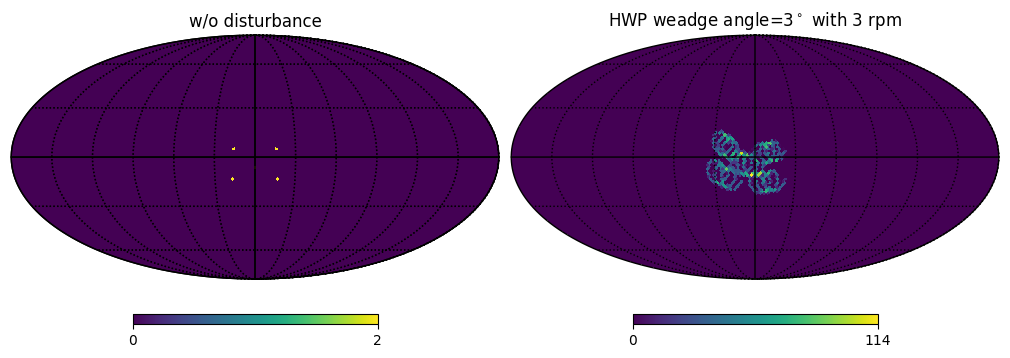

In [18]:
nside = 32
hitmap = get_hitmap(
    nside,
    pointings_no_syst[
        :,
        :1,
        :,
    ],
)

plt.figure(figsize=(10, 7))
hp.mollview(hitmap, sub=(1, 2, 1), title="w/o disturbance")
hp.graticule()

hitmap_sys = get_hitmap(nside, pointings_list)
hp.mollview(
    hitmap_sys,
    sub=(1, 2, 2),
    title=f"HWP weadge angle={wedge_angle_deg}$^\circ$ with {hwp_rpm} rpm",
)
hp.graticule()

## TOD generation

Now, we demonstrate an example of TOD generation with the pointing systematics.
Let's redefine the `Simulation` and list of detectors.


In [ ]:
telescope = "LFT"
channel = "L4-140"
detlist = ["000_001_017_QB_140_T", "000_001_017_QB_140_B"]

start_time = 0
imo_version = "vPTEP"
imo = lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION)

mission_time_days = 180
duration_s = mission_time_days * 24 * 3600.0
sampling_hz = 1.0
random_seed = 12345
nside = 64


def gen_sim_and_dets_from_imo(
    telescope, duration_s, sampling_hz, random_seed, hwp_rpm=None, scan_strategy=True
):
    """Generate a simulation and detectors with a argument of scan_strategy.
    If scan_strategy is True, the scanning strategy is set by the IMO file.
    If scan_strategy is False, the spacecraft stops spinning and precession.
    """
    sim = lbs.Simulation(
        start_time=start_time, duration_s=duration_s, random_seed=random_seed
    )
    sim.set_scanning_strategy(
        imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/",
        delta_time_s=1.0 / sampling_hz,
    )
    if scan_strategy:
        sim.set_scanning_strategy(
            imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/",
            delta_time_s=1.0 / sampling_hz,
        )
    else:
        sim.set_scanning_strategy(
            scanning_strategy=lbs.SpinningScanningStrategy(
                spin_sun_angle_rad=np.deg2rad(45.0),
                spin_rate_hz=0.0,
                precession_rate_hz=0.0,
            ),
            delta_time_s=1.0 / sampling_hz,
        )
    sim.set_instrument(
        lbs.InstrumentInfo.from_imo(
            imo,
            f"/releases/{imo_version}/satellite/{telescope}/instrument_info",
        )
    )
    if hwp_rpm is not None:
        sim.set_hwp(lbs.IdealHWP(hwp_rpm * 2 * np.pi / 60))
        sim.instrument.hwp_rpm = hwp_rpm
    else:
        sim.set_hwp(lbs.IdealHWP(sim.instrument.hwp_rpm * 2 * np.pi / 60))

    dets = []
    for n_det in detlist:
        det = lbs.DetectorInfo.from_imo(
            url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/{n_det}/detector_info",
            imo=imo,
        )
        det.sampling_rate_hz = sampling_hz
        dets.append(det)

    return sim, dets

In [20]:
# loading channel info
ch_info = []
ch_info.append(
    lbs.FreqChannelInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info",
        imo=imo,
    )
)

# let's make an input CMB+foreground map
# this sets the parameters for the generation of the map
Mbsparams = lbs.MbsParameters(
    make_cmb=True,
    make_fg=False,
    seed_cmb=1,  # set this seed if you want to fix the CMB realization
    fg_models=[
        "pysm_synch_0",
        "pysm_dust_0",
    ],  # set the FG models you want
    gaussian_smooth=True,  # if True, smooths the input map by the beam of the channel
    bandpass_int=False,  # if True, integrates over the top-hat bandpass of the channel
    nside=nside,
    units="K_CMB",
    maps_in_ecliptic=False,
)

mbs = lbs.Mbs(
    simulation=sim,
    parameters=Mbsparams,
    channel_list=ch_info,
    # detector_list = dets      #use detector_list instead of channel_list if your sim has detectors
    # from different channels. It would produce a map for each detector in dets
)
maps = mbs.run_all()[0]  # generates the map as a dictionary

[2024-11-15 00:17:17,516 INFO MPI#0000] generating and saving cmb simulations
[2024-11-15 00:17:17,595 INFO MPI#0000] Access data from /data/t/t541/litebird/lbsim_branches/litebird_sim/notebooks/cmb/0000/cmb_0000_date_241115.fits


## Example of the pointing offset in the spacecraft


In [ ]:
# Define `Simulation` and `List[Detector]` without pointing systematics.
sim, dets = gen_sim_and_dets_from_imo(telescope, duration_s, sampling_hz, random_seed)
# Define `Simulation` and `List[Detector]` to be injected pointing systematics.
sim_sys, dets_sys = gen_sim_and_dets_from_imo(
    telescope, duration_s, sampling_hz, random_seed
)
# create the observations
sim.create_observations(detectors=dets)
sim_sys.create_observations(detectors=dets_sys)

# make `PointingSys` instance
pntsys = lbs.PointingSys(sim_sys, sim_sys.observations[0], dets_sys)

In [22]:
# Add the global offset to the focal plane
global_offset_deg = 0.1
axis = "x"
pntsys.spacecraft.add_offset(np.deg2rad(global_offset_deg), axis)

# prepare the pointing
sim.prepare_pointings()
sim_sys.prepare_pointings()

lbs.precompute_pointings(sim.observations)
lbs.precompute_pointings(sim_sys.observations)

n_obs = len(sim.observations)
pointings = [sim.observations[i_obs].pointing_matrix for i_obs in range(n_obs)]
pointings_sys = [sim_sys.observations[i_obs].pointing_matrix for i_obs in range(n_obs)]

In [23]:
# scan the map in the observations
lbs.scan_map_in_observations(
    sim.observations,
    pointings=pointings,
    maps=maps,
    input_map_in_galactic=True,
    interpolation="linear",  # TOD will be generated by bi-linear interpolation of the map
)

lbs.scan_map_in_observations(
    sim_sys.observations,
    pointings=pointings_sys,
    maps=maps,
    input_map_in_galactic=True,
    interpolation="linear",
)

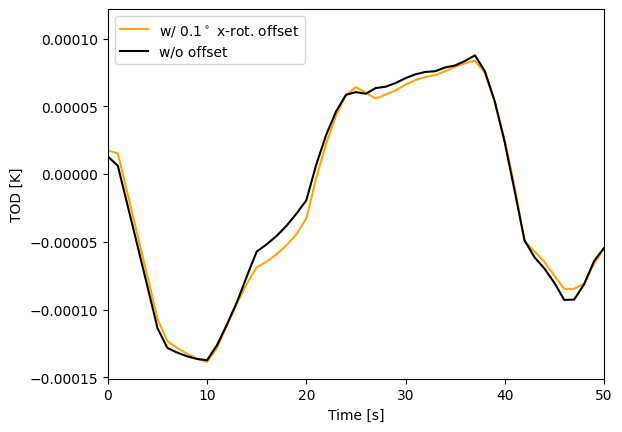

In [ ]:
# plot TODs with and without systematics
time = sim.observations[0].get_times()
sample_lim = 100
plt.plot(
    time[:sample_lim],
    sim_sys.observations[0].tod[0][:sample_lim],
    "-",
    label=f"w/ {global_offset_deg}$^\circ$ {axis}-rot. offset",
    color="orange",
)

plt.plot(
    time[:sample_lim],
    sim.observations[0].tod[0][:sample_lim],
    "-",
    label="w/o offset",
    color="black",
)

plt.xlim(0, 50)
plt.xlabel("Time [s]")
plt.ylabel("TOD [K]")
plt.legend()

# Let's make maps with pointing systematics.

We reconstruct the observed maps by TODs which generated by systeamtic pointing (stored in `sim_sys.observations`) with expected pointing (`pointings`).


In [ ]:
binner_results = lbs.make_binned_map(
    nside=nside,  # one can set also a different resolution than the input map
    observations=sim_sys.observations,  # includes TOD generated by systematic pointing
    pointings=pointings,  # pointing without systematics
    output_coordinate_system=lbs.CoordinateSystem.Galactic,
)

Bottom right is input map of $I$ and middle is observed map with pointing systematiscs.
The left map is the systematics residual map.


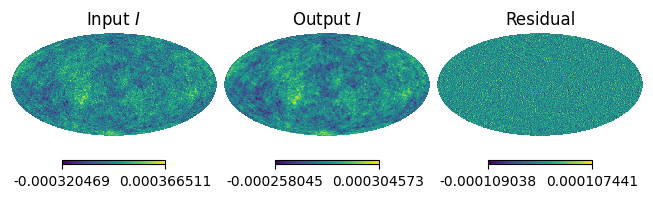

In [ ]:
hp.mollview(maps["L4-140"][0], sub=(1, 3, 1), title="Input $I$")
hp.mollview(binner_results.binned_map[0], sub=(1, 3, 2), title="Output $I$")
hp.mollview(
    maps["L4-140"][0] - binner_results.binned_map[0], sub=(1, 3, 3), title="Residual"
)

## Example of the random disturbance in the spacecraft


In [ ]:
# Define `Simulation` and `List[Detector]` without pointing systematics.
duration_s = 3600.0
sampling_hz = 19.0

sim, dets = gen_sim_and_dets_from_imo(telescope, duration_s, sampling_hz, random_seed)
# Define `Simulation` and `List[Detector]` to be injected pointing systematics.
sim_sys, dets_sys = gen_sim_and_dets_from_imo(
    telescope, duration_s, sampling_hz, random_seed
)
# create the observations
sim.create_observations(detectors=dets)
sim_sys.create_observations(detectors=dets_sys)

pntsys = lbs.PointingSys(sim_sys, sim_sys.observations[0], dets_sys)

In [28]:
nquats = sim_sys.spin2ecliptic_quats.quats.shape[0]

noise_rad_array_x = np.zeros(nquats)
noise_rad_array_y = np.zeros(nquats)
noise_sigma_deg = 0.05

# make a white noise with the unit of radian.
lbs.add_white_noise(
    noise_rad_array_x, sigma=np.deg2rad(noise_sigma_deg), random=sim_sys.random
)
lbs.add_white_noise(
    noise_rad_array_y, sigma=np.deg2rad(noise_sigma_deg), random=sim_sys.random
)
# Add the white noise to the focal plane
pntsys.spacecraft.add_disturb(noise_rad_array_x, "x")
pntsys.spacecraft.add_disturb(noise_rad_array_y, "y")

In [29]:
# prepare the pointing
sim.prepare_pointings()
sim_sys.prepare_pointings()

# scan the map in the observations
lbs.scan_map_in_observations(
    sim.observations,
    maps=maps,
    input_map_in_galactic=True,
    interpolation="linear",  # TOD will be generated by bi-linear interpolation of the map
)

lbs.scan_map_in_observations(
    sim_sys.observations,
    maps=maps,
    input_map_in_galactic=True,
    interpolation="linear",
)

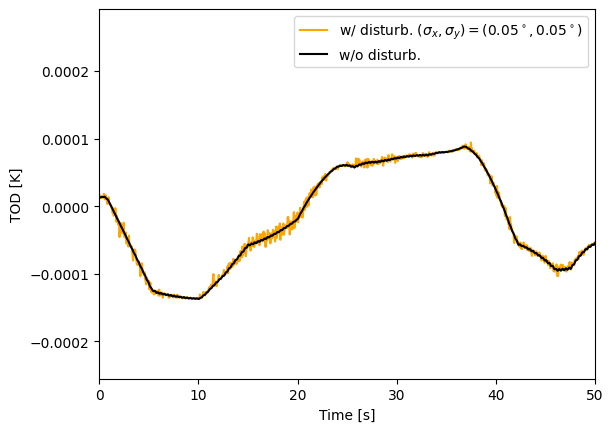

In [ ]:
# plot TODs with and without systematics
time = sim.observations[0].get_times()
plt.plot(
    time,
    sim_sys.observations[0].tod[0],
    "-",
    label=f"w/ disturb. $(\sigma_x, \sigma_y)=({noise_sigma_deg}^\circ, {noise_sigma_deg}^\circ)$",
    color="orange",
)

plt.plot(time, sim.observations[0].tod[0], "-", label="w/o disturb.", color="black")

plt.xlim(0, 50)
plt.xlabel("Time [s]")
plt.ylabel("TOD [K]")
plt.legend()

# Example of HWP wedge effect for pointings

We assume a wedged transmissive HWP here, which rotate pointings around the expected pointing direction.
Here, we set 60 rpm i.e. 1 Hz as the HWP rotation speed, so we expect it cause the $1f$-effect in TOD.


In [ ]:
# Define `Simulation` and `List[Detector]` without pointing systematics.
duration_s = 1000
sampling_hz = 19.0
hwp_rpm = 60.0
scan = True

sim, dets = gen_sim_and_dets_from_imo(
    telescope, duration_s, sampling_hz, random_seed, hwp_rpm=hwp_rpm, scan_strategy=scan
)

# Define `Simulation` and `List[Detector]` to be injected pointing systematics.
sim_sys, dets_sys = gen_sim_and_dets_from_imo(
    telescope, duration_s, sampling_hz, random_seed, hwp_rpm=hwp_rpm, scan_strategy=scan
)
# create the observations
sim.create_observations(detectors=dets)
sim_sys.create_observations(detectors=dets_sys)

# make a pointing systematics instance
pntsys = lbs.PointingSys(sim_sys, sim_sys.observations[0], dets_sys)

wedge_angle_arcmin = 1.0  # wedge angle of the HWP
refractive_idx = 3.1  # refractive index of HWP
wedge_angle_rad = np.deg2rad(wedge_angle_arcmin / 60)

tilt_angle_rad = pntsys.hwp.get_wedgeHWP_pointing_shift_angle(
    wedge_angle_rad, refractive_idx
)

ang_speed_radpsec = hwp_rpm * 2 * np.pi / 60
tilt_phase_rad = 0

# add rotational disturbance to detector's quaternion
pntsys.hwp.add_hwp_rot_disturb(tilt_angle_rad, ang_speed_radpsec, tilt_phase_rad)

# prepare pointings and compute it
sim.prepare_pointings()
sim_sys.prepare_pointings()
lbs.precompute_pointings(sim.observations)
lbs.precompute_pointings(sim_sys.observations)

n_obs = len(sim.observations)
pointings_sys = [sim_sys.observations[i_obs].pointing_matrix for i_obs in range(n_obs)]
pointings = [sim.observations[i_obs].pointing_matrix for i_obs in range(n_obs)]

In [32]:
# make TODs with and without systematics
lbs.scan_map_in_observations(
    sim.observations,
    maps=maps,
    input_map_in_galactic=True,
    interpolation="linear",
)

lbs.scan_map_in_observations(
    sim_sys.observations,
    maps=maps,
    input_map_in_galactic=True,
    interpolation="linear",
)

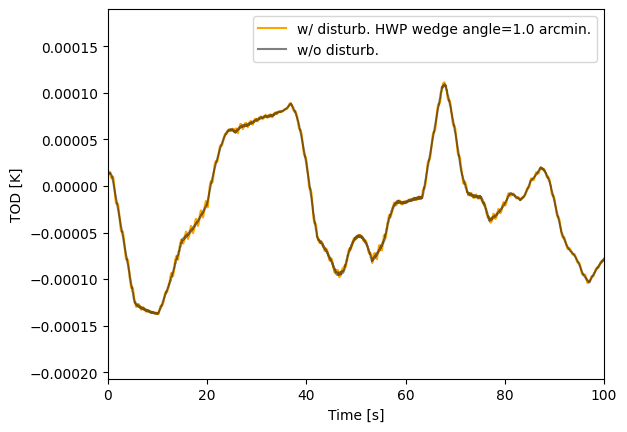

In [ ]:
# plot TODs with and without systematics
time = sim.observations[0].get_times()
plt.plot(
    time,
    sim_sys.observations[0].tod[0],
    "-",
    label=f"w/ disturb. HWP wedge angle={wedge_angle_arcmin} arcmin.",
    color="orange",
)

plt.plot(
    time,
    sim.observations[0].tod[0],
    "-",
    label="w/o disturb.",
    color="black",
    alpha=0.5,
)
plt.xlim(0, 100)
plt.xlabel("Time [s]")
plt.ylabel("TOD [K]")
plt.legend()

# Power spectrum of TODs

We can clealy see the $1f$ systematics peak and $4f$ modulation peak.


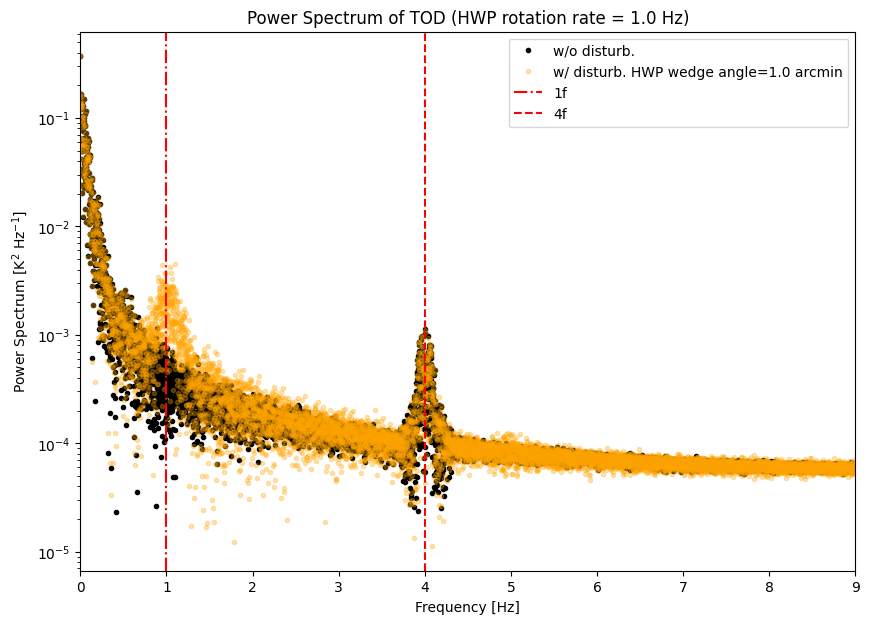

In [ ]:
ps = np.fft.fft(sim.observations[0].tod[0])
ps_sys = np.fft.fft(sim_sys.observations[0].tod[0])
freqs = np.fft.fftfreq(len(ps), d=1 / sampling_hz)

plt.figure(figsize=(10, 7))
plt.title(f"Power Spectrum of TOD (HWP rotation rate = {hwp_rpm/60} Hz)")
plt.plot(freqs, np.abs(ps), ".", label="w/o disturb.", color="black")
plt.plot(
    freqs,
    np.abs(ps_sys),
    ".",
    label=f"w/ disturb. HWP wedge angle={wedge_angle_arcmin} arcmin",
    color="orange",
    alpha=0.3,
)
plt.axvline(hwp_rpm / 60, linestyle="-.", label="1f", color="red")
plt.axvline(4 * hwp_rpm / 60, linestyle="--", label="4f", color="red")
plt.yscale("log")
plt.xlim(0, 9)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power Spectrum [K$^2$ Hz$^{-1}$]")
plt.legend()